## Transfer Learning using Convlutional Neural Networks:

# I. Training from scratch 

In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import vgg16, resnet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print(tf.config.list_physical_devices("GPU"))

[]


# 2.  Cifar10 Dataset

The CIFAR10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Cifar10 dataset already exist on TensorFlow. Load these images using load_data() function from cifar10 module, which return train and test sets (x_train, y_train), (x_test, y_test).

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Using the "train_test_split" sklearn function in order to split the train dataset into train/validation subsets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)

train_shape = x_train.shape
test_shape = x_test.shape
val_shape = x_val.shape

num_classes = np.max(y_test) + 1

print("Number of train images", train_shape[0])
print("Number of test images", test_shape[0])
print("Number of val images", val_shape[0])
print("Number of classes", num_classes)
print("Image size", train_shape[1:])

Number of train images 40000
Number of test images 10000
Number of val images 10000
Number of classes 10
Image size (32, 32, 3)


#  Data visualization

Dispaly one image per class from the training or the testing datasets

Using the given classes name, display the corresponding class name for each image.

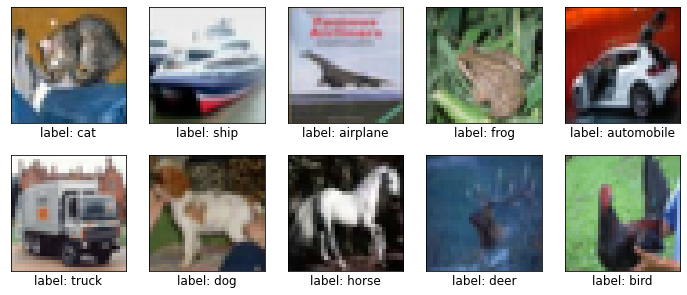

In [ ]:
classes_name = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

X = []
Y = []

for i, y in enumerate(y_test):
    if y in Y:
        continue
    
    Y.append(y)
    X.append(x_test[i])


fig = plt.figure(figsize = (12, 5))

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, i + 1)
    img = X[i]
    lbl = classes_name[int(Y[i])]
    ax.set_xlabel("label: {}".format(lbl), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img, cmap = 'gray')

plt.show()

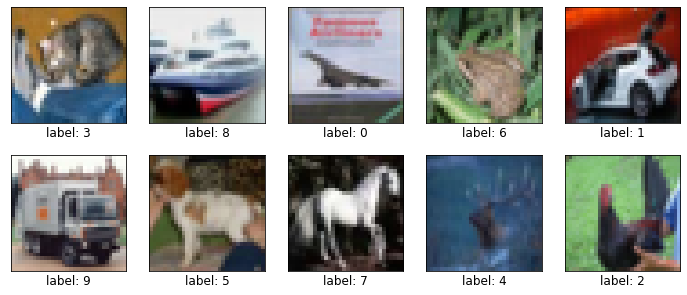

In [ ]:
classes_name = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

X = []
Y = []

for i, y in enumerate(y_test):
    if y in Y:
        continue
    
    Y.append(y)
    X.append(x_test[i])


fig = plt.figure(figsize = (12, 5))

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, i + 1)
    img = X[i]
    lbl = Y[i]
    ax.set_xlabel("label: {}".format(lbl[0]), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img, cmap = 'gray')

plt.show()

# Data Preprocessing

Images are represented in 8-bits integer in range [0-255]. 

You have to normalizing the pixel values range from [0-255] integer to [0-1] float



In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val / 255.0

# 3. Train VGG16 on Cifar10 Benchmark from Scratch

We instantiate the VGG16 [1] model from TensorFlow application, then we remove the top layer (classification layer) since it correspond to 1000 classes of ImageNet [2]

Notice that we load only the feature extraction part of VGG16 architecture, the weights are randomly initialized. You will add the classification layer later

vgg16.VGG16 function() will create the vgg16 model for you, we indicate that we want to remove the calssification layer by initializing include_top by False. 

You need to train your model from scratch. To do so, you need to initialize weights by None. Otherwise, you will get a pretrained model with imagenet weights.

**References**

[1] Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.

[2] Deng, J. et al., 2009. Imagenet: A large-scale hierarchical image database. In 2009 IEEE conference on computer vision and pattern recognition. pp. 248–255.

In [ ]:
vgg16_model = vgg16.VGG16(input_shape = (32, 32, 3), include_top = False, weights = None)

classification_layers() function takes as input your the base-model (feature extraction part), then connect it to the classification part.

In this case we add only one layer on the top of VGG16 base-model, which is the output layer.

You can customize your classifcation layers as you want (number of Dense layers, number of neurones per layer...)


In [ ]:
def classification_layers(model):
  x = Flatten()(model.layers[-1].output)
  x = Dense(10, activation = 'softmax')(x)
  return x

In the following cell, you will be able to create your custom model. 

Using Model class from tf.keras.Model, which take as elements the "inputs" and the "outputs", then return the model instance.

- model "input" is taken from the loaded vgg16_model.input

- model "output" given by the classification_layers that we have already created.


In [ ]:
output = classification_layers(vgg16_model)

# smodel refer to scatch model.
smodel = Model(inputs = vgg16_model.input, outputs = output)

# model.summary() will display a summary for your generated model.
smodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

# 4. Hyperparameters

In this cell, we set the hyperparameters:

- batch_size: Is the amount of data feed into the network once before performing one update

- epochs: The number of training iteration

- Learning_rate: Control how fast we make updates on the weights during the training process

In [ ]:
batch_size = 128
epochs = 40
learning_rate = 0.1
lr_decay = 0.1

# Learning rate decay functions 

The following functions correspond to different learning rate scheduler:

1. step_decay : step-based learning rate decay. The initial learning rate is divided after performing several epochs.
2. exp_decay : exponential-based learning rate decay. The learning rate value will follow the expontial form starting from the initial value.

In [ ]:
#Step decay
def step_decay(epoch):

    lr = learning_rate
    if epoch > 30:
        lr = lr * lr_decay**3
    elif epoch > 20:
        lr = lr * lr_decay**2   
    elif epoch > 10:
        lr = lr * lr_decay

    return lr

#Exponential decay
def exp_decay(epoch):
    
    lr = learning_rate * np.exp(-lr_decay * epoch)

    return lr

# Optimizer and loss function

In the following cell, we: 
- define the loss function for our Model which is the Crossentropy function.
- initialize the Gradient Descent Optimizer "SGD".
- configure the model before training. We use for that "model.compile(...)"
- metrics of evaluation for this model is the accuracy
- callbakcs are functions called during training at certain points, to do some process (Saving the best checkpoint, Adjusting the learning rate...)
    1. LearningRateScheduler : Used to adjust the learning rate during training.
    2. ModelCheckpoint : Used for saving the best model according to the validation accuracy during training.

In [ ]:
loss = "SparseCategoricalCrossentropy"

opt = SGD(learning_rate=learning_rate)

smodel.compile(optimizer=opt, loss = loss, metrics = ["accuracy"])

model_name_scratch = "vgg16_fromscratch"

lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
checkpoint = ModelCheckpoint(filepath="./saved_models/{}.hdf5".format(model_name_scratch), save_best_only=True, monitor="val_accuracy", verbose=1)

#Group all your callbacks into a list for later use.
callbacks = [lr_scheduler, checkpoint]

# Model training

Now that our model is ready, we can start learning using the function "model.fit".

First, we have to shuffle our training data (shuffle = True).

The list of callbacks predefined previously is given to the model.fit()

=> Analyze the parameters of the function "model.fit". The output of this funtion is deeply analyzed in the next cell.

In [ ]:
sh = smodel.fit(x_train, y_train, epochs = epochs, batch_size=batch_size, validation_data = (x_val, y_val), shuffle = True)

Epoch 1/40
 39/313 [==>...........................] - ETA: 58:29 - loss: 2.3029 - accuracy: 0.0964

# 5. VGG16 model performance on Cifar10 (Training from Scratch)

Let's analyze the logs of training.

Here, we plot train and validation accuracy during traning.

We also plot the loss w.r.t. epochs.

- Comment the results

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(sh.history["accuracy"], label = "train_acc")
plt.plot(sh.history["val_accuracy"], label = "val_acc")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(sh.history["loss"], label = "train_loss")
plt.plot(sh.history["val_loss"], label = "val_loss")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.show()

# Evaluation on the test set

The funtion "model.evaluate" can be used to evaluate the performance of the model on the testset.


First of all you need to load the best checkpoint saved by ModelCheckpoint callback. Otherwise, you would evaluate the last train step model.

In [ ]:
smodel = load_model(checkpoint)
smodel.evaluate(...)

313/313 [==============================] - 3s 8ms/step - loss: 1.7483 - accuracy: 0.6785


[1.748268961906433, 0.6784999966621399]

# II. Transfer learning of VGG16 pretrained model on Cifar10 Benchmark


After you have make a training from scratch of VGG16 on Cifar-10, from this section you will apply the transfer learning technique on the same application. 

You need only to set "weights" to "imagenet" inorder to load the pretrained VGG16 weights trained on ImageNet dataset.

Imagenet dataset consists of 1.78 million different shape colour images in 1000 classes, with ~1000 images per class. There are 1.28 million training images and 50000 test images

In [ ]:
vgg16_model = vgg16.VGG16(input_shape = (32, 32, 3), include_top = False, weights = "imagenet")

In the following cell, you will be able to create your custom model.

- Regarding model building using tf.keras.Model, nothing is changed for model compared to the training from scratch part.

In [ ]:
output = classification_layers(vgg16_model)

TLmodel = Model(inputs = vgg16_model.input, outputs = output)

TLmodel.summary()

# 1. Freezing the base-model

Inorder to perform transfer learning, we should keep the feature extraction part frozen. 

As default, all the layers are trainable. You should iterate through all the layers inorder to freeze the base-model using layer.trainable = False.

In [ ]:
#Freezing the Conv layers
for layer in TLmodel.layers:
  if isinstance(layer, Dense):
    break
  layer.trainable = False

# 2. Optimizer and loss function

We keep the same configuration as in training from scratch for a fair comparaison.

In [ ]:
loss = "SparseCategoricalCrossentropy"

opt = SGD(learning_rate=learning_rate)

TLmodel.compile(optimizer=opt, loss = loss, metrics = ["accuracy"])

TL_model_name = "vgg16_transferlearning"

lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
checkpoint = ModelCheckpoint(filepath="./saved_models/{}.hdf5".format(TL_model_name), save_best_only=True, monitor="val_accuracy", verbose=1)
callbacks = [lr_scheduler, checkpoint]

Fit your model as before using "fit" function.

In [ ]:
th = TLmodel.fit(...)

# Evaluation on the test set

Evaluate the obtained model with "evaluate" function using the test set used before.

First of all you need to load the best checkpoint saved by ModelCheckpoint callback. Otherwise, you would evaluate the last train step model.

In [ ]:
TLmodel = load_model(...)
TLmodel.evaluate(...)

# 3. Display the Training & Validation plots

Let's analyze the logs of training.

Here, we plot train and validation accuracy during traning.

We also plot the loss w.r.t. epochs.

- Comment the results

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(th.history["accuracy"], label = "train_acc")
plt.plot(th.history["val_accuracy"], label = "val_acc")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(th.history["loss"], label = "train_loss")
plt.plot(th.history["val_loss"], label = "val_loss")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.show()

# III. Fine tuning

As you know, fine tuning is an important step that could improve the model performence rightafter applying the transfer learning.

To do so, you should load the best checkpoint your model (obtained with transfer learning) as a starting point for the fine tuning process.

In [ ]:
FTmodel = load_model(...)

# 1. How much layer should we freeze?

In this cell you will be able to take the control on how much layer you should freeze using the slide bar

1. You should execute this cell once to be able to see the slide barr.
2. For the first step, make all the layers trainable (trainable convX : True), then execute all the reamining cells untill the end.
3. Make sure that you have saved your model and plots for the previous test.
4. Reload again the model from the previous cell to remake a new test
5. For the second test, do not freeze all the layers, make some of them unfreeze. You should keep the same configuration of hyperparameters for a fair comparaison.
6. Feel free to do several experiments.

In [ ]:
# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact

conv_layers = [layer for layer in FTmodel.layers if isinstance(layer, tf.keras.layers.Conv2D)]

number_of_convs = len(conv_layers)
# use interact decorator to decorate the function, so the function can receive the slide bar's value with parameter x.
print(number_of_convs)
@interact(x=(0, number_of_convs))
def double_number(x):

    #Freezing the Conv layers
    for layer in FTmodel.layers:
        if isinstance(layer, Dense):
            break
        layer.trainable = False

    i = 0
    for layer in FTmodel.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            if i < x:
                layer.trainable = True
                i+=1
            else:
                break
            
    
    i = 1
    for layer in FTmodel.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            print("Train conv{} : {}".format(i, layer.trainable))
            i+=1

13


interactive(children=(IntSlider(value=6, description='x', max=13), Output()), _dom_classes=('widget-interact',…

# 2. Optimizer and loss function

The only change on the following cell is the learning rate value. You should start with smaller learning rate. 

Divide the initial learning rate by 10 for example.  

In [ ]:
loss = "SparseCategoricalCrossentropy"

learning_rate = 0.1
learning_rate = learning_rate / 10

opt = SGD(learning_rate=learning_rate)

FTmodel.compile(optimizer=opt, loss = loss, metrics = ["accuracy"])

FT_model_name = "vgg16_finetuning"

lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
checkpoint = ModelCheckpoint(filepath="./saved_models/{}.hdf5".format(FT_model_name), save_best_only=True, monitor="val_accuracy", verbose=1)
callbacks = [lr_scheduler, checkpoint]

Start fine tuning !

In [ ]:
fh = FTmodel.fit(...)

# Evaluation on the test set

Load the best checkpoint that achieved the higher val_accuracy during fine tuning using load_model function.

Evaluate the loaded model.

In [ ]:
FTmodel = load_model(...)
FTmodel.evaluate(...)

# 3. Display the Training & Validation plots

Let's analyze the logs of fine tuning.

Here, we plot train/validation accuracy/loss respectively during the fine tuning.

Comment the obtained result for each test in case :
- Fine tune the whole model
- Fine tune a part of the feature extraction model
- Comment and explain the results in all the cases


In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(fh.history["accuracy"], label = "train_acc")
plt.plot(fh.history["val_accuracy"], label = "val_acc")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(fh.history["loss"], label = "train_loss")
plt.plot(fh.history["val_loss"], label = "val_loss")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.show()